# COVID-19 Detection 
## Results
### InceptionV3
| Epochs | Training Loss | Training Accuracy | Validation Loss | Validation Accuracy | Preprocessing Functions | 
| ----- | ----- | ----- | ----- | ----- | ----- |  
| 186 | 0.0854 | 96.95% | 0.1080 | 97.03% | Cropping, convert to XYZ, MT with SE = 35 |
| 194 | 0.0846 | 97.54% | 0.1291 | 95.78% | Cropping, convert to XYZ, MT with SE = 35 |
| 195 | 0.0784 | 97.23% | 0.1145 | 95.86% | Cropping, convert to XYZ, MT with SE = 35 |
| 196 | 0.0734 | 97.11% | 0.1432 | 95.94% | Cropping, convert to XYZ, MT with SE = 35 |
| 199 | 0.0562 | 98.14% | 0.0902 | 96.72% | None |

### VGG19
| Epochs | Training Loss | Training Accuracy | Validation Loss | Validation Accuracy | Preprocessing Functions | 
| ----- | ----- | ----- | ----- | ----- | ----- |  
| 173 | 0.1368 | 95.05% | 0.1651 | 93.20% | None |
| 192 | 0.1801 | 92.99% | 0.2294 | 91.64% | Cropping, CLAHE |


### EfficientNetB7
| Epochs | Training Loss | Training Accuracy | Validation Loss | Validation Accuracy | Preprocessing Functions | 
| ----- | ----- | ----- | ----- | ----- | ----- |  
| 200 | 0.5816 | 73.39% | 0.5885 | 74.14% | None |
| 105 | 0.5652 | 75.42% | 0.5730 | 72.97% | Cropping, convert to XYZ, MT with SE = 35 |

### DenseNet169
| Epochs | Training Loss | Training Accuracy | Validation Loss | Validation Accuracy | Preprocessing Functions | 
| ----- | ----- | ----- | ----- | ----- | ----- |  
| - | - | - | - | - | - |

In [3]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2 as cv
import numpy as np
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint

In [4]:
ROOT_DIR = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset'
PATH_TO_COVID_IMAGES = os.path.join(ROOT_DIR, 'COVID')
PATH_TO_NORMAL_IMAGES = os.path.join(ROOT_DIR, 'Normal')

In [5]:
covid_images = os.listdir(PATH_TO_COVID_IMAGES)
normal_images = os.listdir(PATH_TO_NORMAL_IMAGES)

print(len(covid_images))
print(len(normal_images))

3616
10192


In [6]:
# Training Parameters
INPUT_SHAPE = (150, 150, 3)

DROPOUT = 0.15

LEARNING_RATE = 0.001

LOSS = 'binary_crossentropy'

NUM_OF_EPOCHS = 200

In [7]:
def getBaseModel(model = 'vgg19'):
  # Set model = 'inceptionv3' for Inceptionv3
  if model == 'vgg19':
    vgg19 = tf.keras.applications.vgg19
    base_model = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
  elif model == 'inceptionv3':
    # Download the inception v3 weights
    !wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
    from tensorflow.keras.applications.inception_v3 import InceptionV3
    local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
    base_model = InceptionV3(input_shape=INPUT_SHAPE, include_top=False, weights=None)
    base_model.load_weights(local_weights_file)
  elif model == 'efficientnetb7':
    base_model = tf.keras.applications.EfficientNetB7(weights='imagenet', include_top = False,input_shape = INPUT_SHAPE)
  elif model == 'densenet169':
    base_model = tf.keras.applications.DenseNet169(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
  else:
    return None
  
  # Make all the layers in the pre-trained model non-trainable
  for layer in base_model.layers:
    layer.trainable = False
  
  return base_model

In [8]:
def constructModel(model = 'vgg19'):
  # Set model = 'inceptionv3' for Inceptionv3
  base_model = getBaseModel(model)
  if model == 'vgg19' or model == 'efficientnetb7':
    # flatten the output of the convolutional part: 
    x = tf.keras.layers.Flatten()(base_model.output)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(DROPOUT)(x)                  
#     x = tf.keras.layers.Dense(128, activation='relu')(x)
#     x = tf.keras.layers.Dense(64, activation='relu')(x)
#     x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  elif model == 'inceptionv3':
    last_layer = base_model.get_layer('mixed7')
    last_output = last_layer.output
    # Flatten the output layer to 1 dimension
    x = layers.Flatten()(last_output)
    # Add a fully connected layer with 1,024 hidden units and ReLU activation
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(DROPOUT)(x)                  
    # Add a final sigmoid layer for classification
    x = layers.Dense(1, activation='sigmoid')(x)  
  elif model == 'densenet169':
    x = layers.Flatten()(base_model.output)
    x = tf.keras.layers.Dropout(DROPOUT * 3)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(1, activation='sigmoid')(x)
  else:
    return None
  model = Model(base_model.input, x) 
  model.compile(optimizer = Adam(learning_rate=LEARNING_RATE), loss = LOSS, metrics = ['accuracy'])
  return model

In [12]:
#
# 1. Comment the preprocessing_function = processImage line to not preprocess
#    images before training
# 2. If not commented, run the processImage() function before running this cell

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=5,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2,
#                                    samplewise_center = True,
#                                    samplewise_std_normalization = True,
                                   preprocessing_function = processImage
                                   ) 
                   
train_generator = train_datagen.flow_from_directory(
    ROOT_DIR,
    target_size=(150, 150),
    batch_size=256,
    classes=["COVID", "Normal"],
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    ROOT_DIR, # same directory as training data
    target_size=(150, 150),
    batch_size=256,
    class_mode='binary',
    classes=["COVID", "Normal"],
    subset='validation') # set as validation data


Found 11047 images belonging to 2 classes.
Found 2761 images belonging to 2 classes.


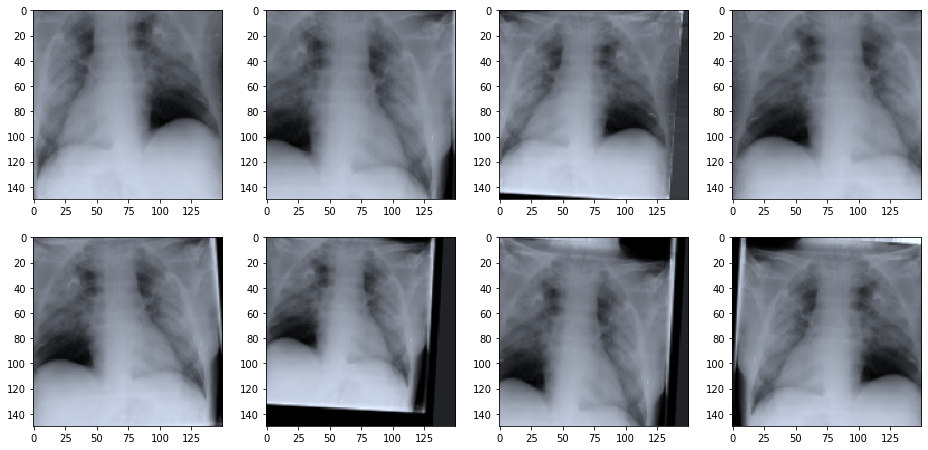

In [13]:
# This cell is used to visualize how ImageDataGenerator will process the images while training

img_path = os.path.join(PATH_TO_COVID_IMAGES, covid_images[15])
img = tf.keras.preprocessing.image.load_img(img_path, target_size= (150,150))
img_tensor = tf.keras.preprocessing.image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

#Creates our batch of one image
pic = train_datagen.flow(img_tensor, batch_size =1)
plt.figure(figsize=(16, 16))
#Plots our figures
for i in range(1,9):
   plt.subplot(4, 4, i)
   batch = pic.next()
   image_ = batch[0]
# .astype('uint8')
   plt.imshow(image_)
plt.show()


In [9]:
## Choose a model to run

model = constructModel('vgg19')
# model = constructModel('inceptionv3')
# model = constructModel('efficientnetb7')
# model = constructModel('densenet169')

80142336/80134624 [==============================] - 0s 0us/step


In [ ]:
# Callback to save the model .hdf5 file if accuracy improves
# DO NOT RUN THIS IN KAGGLE
filepath="weights-improvement-{epoch:02d}-{accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [14]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=NUM_OF_EPOCHS,
                    steps_per_epoch=10,
                    validation_steps=5,
#                     callbacks=callbacks_list
                    )

Epoch 1/200
10/10 [==============================] - 82s 7s/step - loss: 2.2911 - accuracy: 0.6735 - val_loss: 1.4279 - val_accuracy: 0.7258
Epoch 2/200
10/10 [==============================] - 62s 6s/step - loss: 0.9468 - accuracy: 0.7480 - val_loss: 0.4022 - val_accuracy: 0.8211
Epoch 3/200
10/10 [==============================] - 57s 6s/step - loss: 0.5129 - accuracy: 0.7459 - val_loss: 0.4273 - val_accuracy: 0.8094
Epoch 4/200
10/10 [==============================] - 55s 6s/step - loss: 0.4840 - accuracy: 0.7709 - val_loss: 0.3775 - val_accuracy: 0.8242
Epoch 5/200
10/10 [==============================] - 51s 5s/step - loss: 0.4320 - accuracy: 0.8078 - val_loss: 0.3682 - val_accuracy: 0.8289
Epoch 6/200
10/10 [==============================] - 52s 5s/step - loss: 0.4218 - accuracy: 0.7948 - val_loss: 0.3663 - val_accuracy: 0.8406
Epoch 7/200
10/10 [==============================] - 49s 5s/step - loss: 0.4105 - accuracy: 0.8111 - val_loss: 0.3435 - val_accuracy: 0.8578
Epoch 8/200
1

In [15]:
result = model.evaluate(validation_generator)

11/11 [==============================] - 39s 4s/step - loss: 0.2033 - accuracy: 0.9196


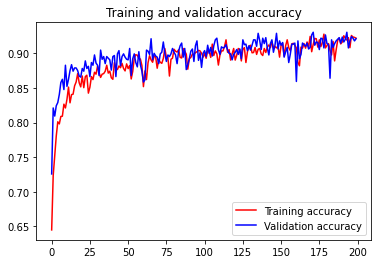

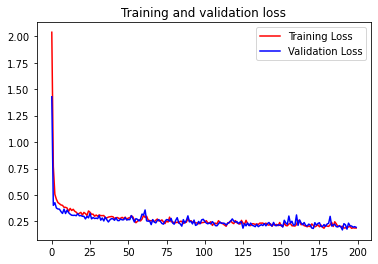

In [16]:
# Plot the chart for accuracy and loss on both training and validation

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# DO NOT RUN THIS
for filename in os.listdir("./"):
    if str(filename).startswith("weights"):
        os.remove(filename)

In [11]:
# Run the functions used here before running this cell
def processImage(image):
    # Crop image
    image = cv.resize(image[10:-10, 10:-10], (150, 150),interpolation = cv.INTER_NEAREST)
    
    # Apply CLAHE
    image = applyCLAHE(image, 3, (5,5))
    
    # Change to XYZ Color Space
    image = cv.cvtColor(image, cv.COLOR_BGR2XYZ)
    
    # Apply Morphological Transform
#     image = combine(image, topHatTransform(image, 35), bottomHatTransform(image, 35)) 
#   return combine(image, topHatTransform(image, 9), bottomHatTransform(image, 9))
    return image


In [ ]:
def topHatTransform(image, SE = 3):
  filterSize = (SE, SE)
  kernel = cv.getStructuringElement(cv.MORPH_RECT, filterSize)
  # Applying the Top-Hat operation
  tophatImg = cv.morphologyEx(image, cv.MORPH_TOPHAT, kernel)
  return tophatImg

def bottomHatTransform(image, SE = 3):
  filterSize = (SE, SE)
  kernel = cv.getStructuringElement(cv.MORPH_RECT, filterSize)
  # Applying the Bottom-Hat operation
  bottomHatImg = cv.morphologyEx(image, cv.MORPH_BLACKHAT, kernel)
  return bottomHatImg

def combine(image, top, bottom):
  return image + top - bottom


In [10]:
def applyCLAHE(img, clipLimit = 2.0, tileGridSize = (8,8)):
  img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  img = img.astype(np.uint16)
  clahe = cv.createCLAHE(clipLimit= clipLimit, tileGridSize= tileGridSize)
  res = clahe.apply(img)
  res = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
  return res.astype(np.float32)